# Introduction / Setup

This notebook shows how to use LangChain's [`LLMGraphTransformer`](https://python.langchain.com/docs/use_cases/graph/constructing/#llm-graph-transformer) to extract knowledge triples and store them in [DataStax AstraDB](https://www.datastax.com/products/datastax-astra).

In [16]:
!python3 --version

Python 3.10.12


In [17]:
# (Optional) When developing locally, this reloads the module code when changes are made,
# making it easier to iterate.
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [18]:
# (Required in Colab) Install the knowledge graph library from the repository.
# This will also install the dependencies.
%pip install https://github.com/datastax-labs/knowledge-graphs-langchain/archive/main.zip

  Using cached https://github.com/datastax-labs/knowledge-graphs-langchain/archive/main.zip
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [19]:
pip install torch_geometric

## Environment
Pick one of the following.
1. If you're just running the notebook, it's probably best to run the cell using `getpass` to set the necessary
   environment variables.
1. If you're developing, it's likely easiest to create a `.env` file and store the necessary credentials.

In [20]:
# (Option 1) - Set the environment variables from getpass.
import getpass
import os

os.environ["OPENAI_API_KEY"] = getpass.getpass("Enter OpenAI API Key: ")
os.environ["ASTRA_DB_DATABASE_ID"] = input("Enter Astra DB Database ID: ")
os.environ["ASTRA_DB_APPLICATION_TOKEN"] = getpass.getpass("Enter Astra DB Application Token: ")

keyspace = input("Enter Astra DB Keyspace (Empty for default): ")
if keyspace:
    os.environ["ASTRA_DB_KEYSPACE"] = keyspace
else:
    os.environ.pop("ASTRA_DB_KEYSPACE", None)

Enter OpenAI API Key: ··········
Enter Astra DB Database ID: 956bf68d-4b5d-46be-ae16-2bc3d49f1fce
Enter Astra DB Application Token: ··········
Enter Astra DB Keyspace (Empty for default): 


In [21]:
# (Option 2) - Load the `.env` file.
# See `env.template` for an example of what you should have there.
%pip install python-dotenv
import dotenv
dotenv.load_dotenv()

False

## Initialize Astra DB / Cassandra

In [22]:
# Initialize cassandra connection from environment variables).
import cassio
cassio.init(auto=True)

ERROR:cassandra.connection:Closing connection <LibevConnection(135740936434304) 956bf68d-4b5d-46be-ae16-2bc3d49f1fce-us-east-2.db.astra.datastax.com:29042:77287bf6-56d6-4541-bd81-8dcabd2de05c> due to protocol error: Error from server: code=000a [Protocol error] message="Beta version of the protocol used (5/v5-beta), but USE_BETA flag is unset"


## Create Graph Store

In [23]:
# Create graph store.
from knowledge_graph.cassandra_graph_store import CassandraGraphStore
graph_store = CassandraGraphStore()

# Extracting Knowledge Graph

In [24]:
from langchain_experimental.graph_transformers import LLMGraphTransformer
from langchain_openai import ChatOpenAI

# Prompt used by LLMGraphTransformer is tuned for Gpt4.
llm = ChatOpenAI(temperature=0, model_name="gpt-4")

llm_transformer = LLMGraphTransformer(llm=llm)

In [239]:
from langchain_core.documents import Document
import networkx as nx

# Generate textual summary of relationships
with open('sample.txt', 'r') as file:
    text = file.read()
documents = [Document(page_content=text)]
graph_documents = llm_transformer.convert_to_graph_documents(documents)
print(f"Nodes:{graph_documents[0].nodes}")
print(f"Relationships:{graph_documents[0].relationships}")

Nodes:[Node(id='Albert Einstein', type='Person'), Node(id='Theory Of Relativity', type='Concept'), Node(id='E=Mc²', type='Concept'), Node(id='Marie Curie', type='Person'), Node(id='Radioactivity', type='Concept'), Node(id='Nobel Prize', type='Award'), Node(id='Physics', type='Field'), Node(id='Chemistry', type='Field'), Node(id='Martin Luther King Jr.', type='Person'), Node(id='Civil Rights', type='Concept'), Node(id='I Have A Dream', type='Speech'), Node(id='Mahatma Gandhi', type='Person'), Node(id='Nonviolent Civil Disobedience', type='Concept'), Node(id='Indian Independence', type='Event'), Node(id='Nelson Mandela', type='Person'), Node(id='Apartheid', type='Concept'), Node(id='South Africa', type='Location'), Node(id='Frida Kahlo', type='Person'), Node(id='Self-Portraits', type='Art'), Node(id='Steve Jobs', type='Person'), Node(id='Apple Inc.', type='Organization'), Node(id='Macintosh', type='Product'), Node(id='Ipod', type='Product'), Node(id='Iphone', type='Product'), Node(id='Ip

In [240]:
# Save the extracted graph documents to the AstraDB / Cassandra Graph Store.
graph_store.add_graph_documents(graph_documents)

In [241]:
from operator import itemgetter
from langchain_core.runnables import RunnableLambda, RunnablePassthrough
from langchain_core.prompts import ChatPromptTemplate
from knowledge_graph import extract_entities
from langchain_openai import ChatOpenAI
llm = ChatOpenAI(model_name = "gpt-4")

def _combine_relations(relations):
    return "\n".join(map(repr, relations))

ANSWER_PROMPT = (
    "The original question is given below."
    "This question has been used to retrieve information from a knowledge graph."
    "The matching triples are shown below."
    "Use the information in the triples to answer the original question.\n\n"
    "Original Question: {question}\n\n"
    "Knowledge Graph Triples:\n{context}\n\n"
    "Response:"
)

chain = (
    { "question": RunnablePassthrough() }
    | RunnablePassthrough.assign(entities = extract_entities(llm))
    | RunnablePassthrough.assign(triples = itemgetter("entities") | graph_store.as_runnable())
    | RunnablePassthrough.assign(context = itemgetter("triples") | RunnableLambda(_combine_relations))
    | ChatPromptTemplate.from_messages([ANSWER_PROMPT])
    | llm
)

#Check Graph Status

In [242]:
# Print the nodes and relationships to verify correctness
for doc in graph_documents:
    print("Nodes:")
    for node in doc.nodes:
        print(f"ID: {node.id}, Type: {node.type}")
    print("\nRelationships:")
    for relationship in doc.relationships:
        print(f"Source: {relationship.source}, Target: {relationship.target}, Type: {relationship.type}")


Nodes:
ID: Albert Einstein, Type: Person
ID: Theory Of Relativity, Type: Concept
ID: E=Mc², Type: Concept
ID: Marie Curie, Type: Person
ID: Radioactivity, Type: Concept
ID: Nobel Prize, Type: Award
ID: Physics, Type: Field
ID: Chemistry, Type: Field
ID: Martin Luther King Jr., Type: Person
ID: Civil Rights, Type: Concept
ID: I Have A Dream, Type: Speech
ID: Mahatma Gandhi, Type: Person
ID: Nonviolent Civil Disobedience, Type: Concept
ID: Indian Independence, Type: Event
ID: Nelson Mandela, Type: Person
ID: Apartheid, Type: Concept
ID: South Africa, Type: Location
ID: Frida Kahlo, Type: Person
ID: Self-Portraits, Type: Art
ID: Steve Jobs, Type: Person
ID: Apple Inc., Type: Organization
ID: Macintosh, Type: Product
ID: Ipod, Type: Product
ID: Iphone, Type: Product
ID: Ipad, Type: Product
ID: Malala Yousafzai, Type: Person
ID: Education Activism, Type: Concept
ID: I Am Malala, Type: Book
ID: Malala Fund, Type: Organization
ID: Leonardo Da Vinci, Type: Person
ID: The Last Supper, Type: Art

#Draw Graph

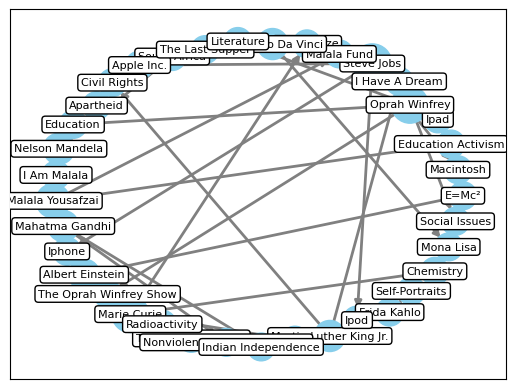

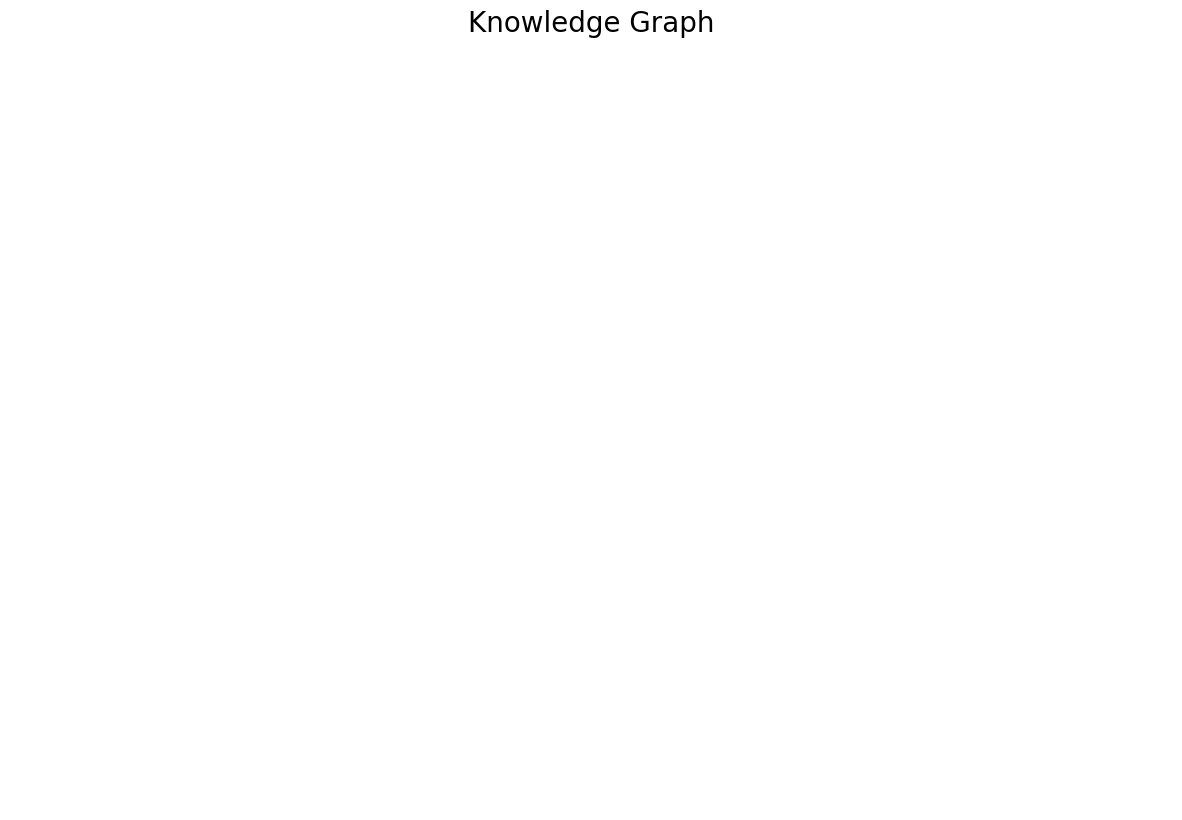

In [243]:
import matplotlib.pyplot as plt

def visualize_graph(graph_documents):
    G = nx.DiGraph()

    # Add nodes and edges to the graph
    for doc in graph_documents:
        for node in doc.nodes:
            if node.id:  # Use only the id for labels
                G.add_node(str(node.id), label=node.id)

        for relationship in doc.relationships:
            if relationship.source and relationship.target:  # Ensure relationships are valid
                G.add_edge(str(relationship.source.id), str(relationship.target.id), label=relationship.type)

    # Identify all nodes that are sources of relationships
    source_nodes = set(relationship.source.id for doc in graph_documents for relationship in doc.relationships)

    # Get positions for the nodes
    pos = nx.spring_layout(G, k=20, iterations=200, center=(0.5, 0.5))  # Increase k value for more spacing

    # Nodes with sizes based on their degree, reduced size
    node_sizes = [300 + 100 * G.degree(node) for node in G.nodes]
    nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color='skyblue')

    # Ensure every node has a label, defaulting to the node ID
    node_labels = {node: G.nodes[node].get('label', node) for node in G.nodes}

    # Node labels with increased font size and padding
    nx.draw_networkx_labels(G, pos, labels=node_labels, font_size=8, font_family='sans-serif',
                            bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.3'))

    # Edges
    nx.draw_networkx_edges(G, pos, edgelist=G.edges(), width=2, edge_color='gray')

    # Edge labels with increased font size
    #edge_labels = nx.get_edge_attributes(G, 'label')
    #nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=8, label_pos=0.5, font_color='black')

    plt.figure(figsize=(15, 10))  # Increase figure size
    plt.title("Knowledge Graph", fontsize=20)
    plt.axis('off')  # Hide axis
    plt.show()
visualize_graph(graph_documents)

In [244]:
# Custom Data class to include num_classes and num_features
class CustomData(Data):
    def __init__(self, num_classes=None, num_features=None, **kwargs):
        super().__init__(**kwargs)
        self.num_classes = num_classes
        self.num_features = num_features

    @classmethod
    def from_data(cls, data, num_classes=None, num_features=None):
        obj = cls(num_classes=num_classes, num_features=num_features, **data.to_dict())
        return obj

In [245]:
import torch
from torch_geometric.data import Data
from community import community_louvain
def convert_to_pyg_data(graph_documents, num_features, num_classes):
    nodes = []
    edges = []

    # Extract nodes and edges from the graph documents
    node_id_map = {}
    for doc in graph_documents:
        for idx, node in enumerate(doc.nodes):
            if node.id not in node_id_map:
                node_id_map[node.id] = len(node_id_map)
                nodes.append(node.id)
        for relationship in doc.relationships:
            source_id = node_id_map[relationship.source.id]
            target_id = node_id_map[relationship.target.id]
            edges.append((source_id, target_id))

    # Convert nodes and edges to PyTorch tensors
    num_nodes = len(node_id_map)
    x = torch.eye(num_nodes, num_features)  # Identity matrix as dummy node features
    y = torch.randint(0, num_classes, (num_nodes,), dtype=torch.long)  # Random labels for demonstration

    # Create train, validation, and test masks
    train_mask = torch.zeros(num_nodes, dtype=torch.bool)
    val_mask = torch.zeros(num_nodes, dtype=torch.bool)
    test_mask = torch.zeros(num_nodes, dtype=torch.bool)

    # Randomly assign nodes to training, validation, and test sets
    train_idx = torch.randperm(num_nodes)[:int(0.8 * num_nodes)]
    val_idx = torch.randperm(num_nodes)[int(0.1 * num_nodes):int(0.2 * num_nodes)]
    test_idx = torch.randperm(num_nodes)[int(0.9 * num_nodes):]

    train_mask[train_idx] = True
    val_mask[val_idx] = True
    test_mask[test_idx] = True

    return CustomData(x=x, edge_index=torch.tensor(edges, dtype=torch.long).t().contiguous(), y=y,
                      train_mask=train_mask, val_mask=val_mask, test_mask=test_mask,
                      num_classes=num_classes, num_features=num_features)

def get_graph_stats(graph_documents):
    G = nx.Graph()

    # Extract nodes and edges from the graph documents to create a networkx graph
    for doc in graph_documents:
        for node in doc.nodes:
            G.add_node(node.id)
        for relationship in doc.relationships:
            G.add_edge(relationship.source.id, relationship.target.id)

    num_features = G.number_of_nodes()

    # Use community detection to find the number of clusters
    partition = community_louvain.best_partition(G)
    num_classes = len(set(partition.values()))

    return num_classes, num_features

#Convert Document Data into Graph Data (Set your Graph's classes and edges)

Number of classes: 10
Number of features: 37


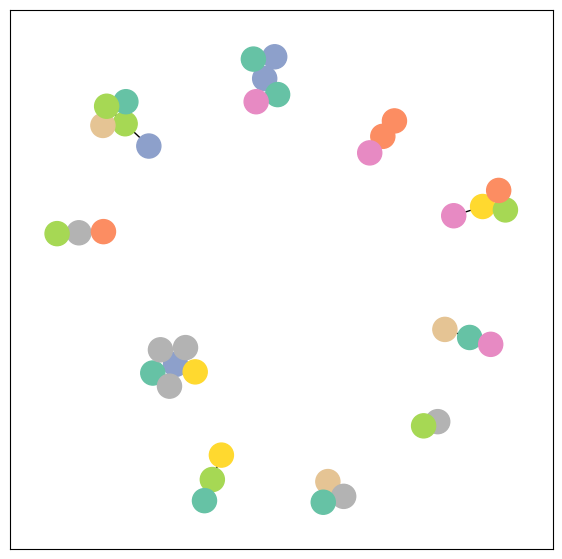

In [246]:
from torch_geometric.utils import to_networkx
def visualize_graph(G, color):
    plt.figure(figsize=(7,7))
    plt.xticks([])
    plt.yticks([])
    nx.draw_networkx(G, pos=nx.spring_layout(G, seed=42), with_labels=False,
                     node_color=color, cmap="Set2")
    plt.show()
num_classes, num_features = get_graph_stats(graph_documents)
print(f'Number of classes: {num_classes}')
print(f'Number of features: {num_features}')
data = convert_to_pyg_data(graph_documents,num_features,num_classes)
G = to_networkx(data, to_undirected=True)
visualize_graph(G, color=data.y)

In [247]:
import torch.nn.functional as F
from torch.nn import Linear, Dropout
from torch_geometric.nn import GCNConv, GATv2Conv


class GCN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        torch.manual_seed(1234)
        self.conv1 = GCNConv(data.num_features, 4)
        self.conv2 = GCNConv(4, 4)
        self.conv3 = GCNConv(4, 2)
        self.classifier = Linear(2, data.num_classes)

    def forward(self, x, edge_index):
        h = self.conv1(x, edge_index)
        h = h.tanh()
        h = self.conv2(h, edge_index)
        h = h.tanh()
        h = self.conv3(h, edge_index)
        h = h.tanh()  # Final GNN embedding space.

        # Apply a final (linear) classifier.
        out = self.classifier(h)

        return out, h


Embedding shape: [37, 2]


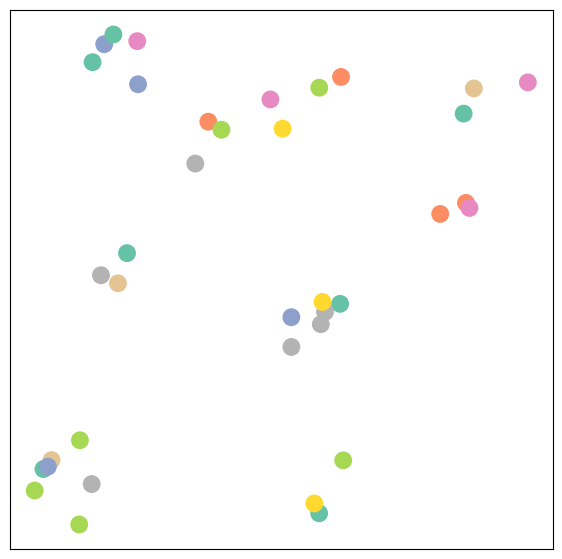

In [248]:
def visualize_embedding(h, color, epoch=None, loss=None):
    plt.figure(figsize=(7,7))
    plt.xticks([])
    plt.yticks([])
    h = h.detach().cpu().numpy()
    plt.scatter(h[:, 0], h[:, 1], s=140, c=color, cmap="Set2")
    if epoch is not None and loss is not None:
        plt.xlabel(f'Epoch: {epoch}, Loss: {loss.item():.4f}', fontsize=16)
    plt.show()
model = GCN()

_, h = model(data.x, data.edge_index)
print(f'Embedding shape: {list(h.shape)}')

visualize_embedding(h, color=data.y)

<IPython.core.display.Javascript object>

Epoch: 0, Loss: 2.4472, Train Acc: 0.0345, Val Acc: 0.0000


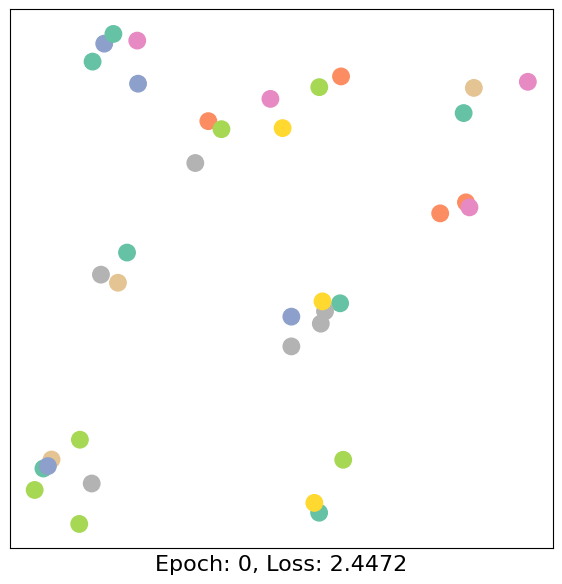

Epoch: 10, Loss: 2.2806, Train Acc: 0.1034, Val Acc: 0.2500


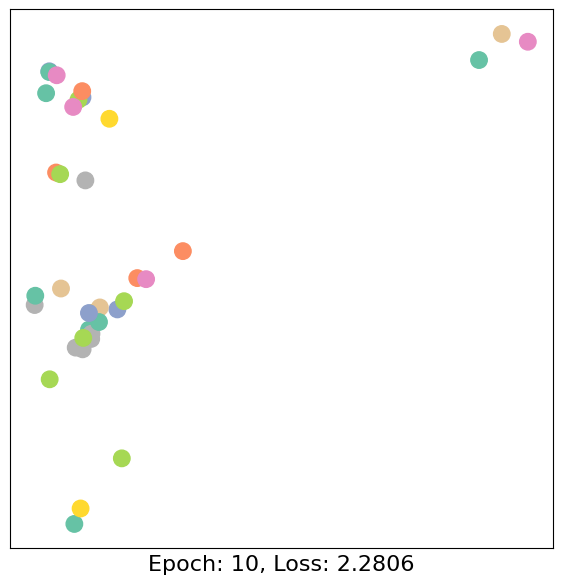

Epoch: 20, Loss: 2.1627, Train Acc: 0.2069, Val Acc: 0.2500


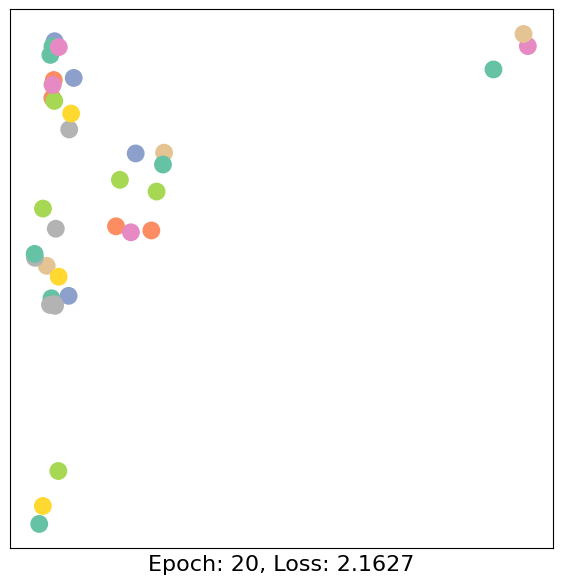

Epoch: 30, Loss: 2.0532, Train Acc: 0.2759, Val Acc: 0.2500


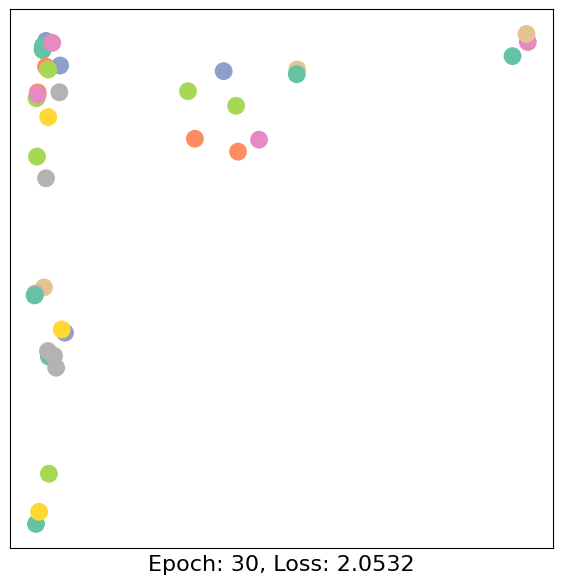

Epoch: 40, Loss: 1.9306, Train Acc: 0.3103, Val Acc: 0.2500


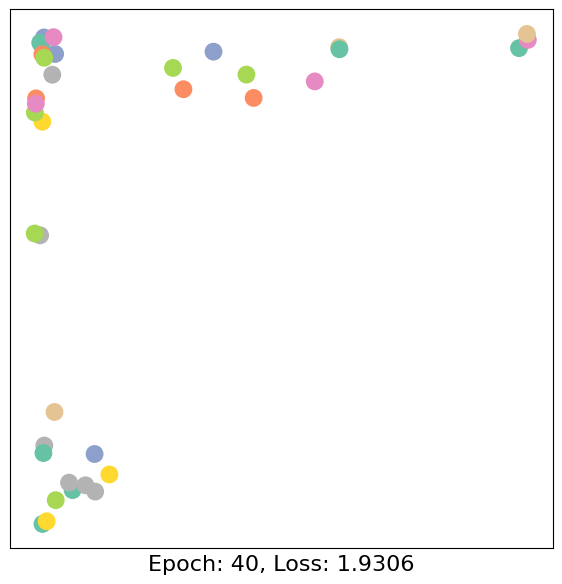

Epoch: 50, Loss: 1.8182, Train Acc: 0.3793, Val Acc: 0.2500


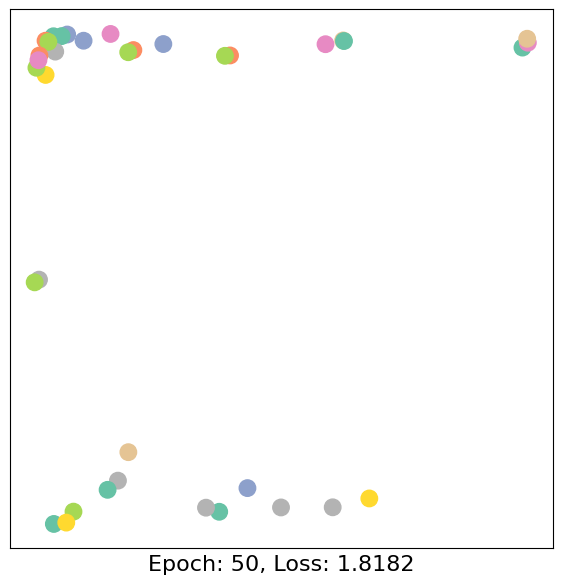

Epoch: 60, Loss: 1.7072, Train Acc: 0.3448, Val Acc: 0.2500


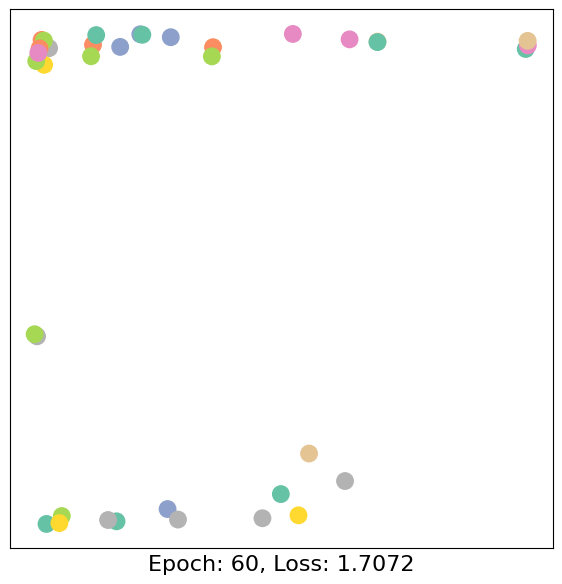

Epoch: 70, Loss: 1.6040, Train Acc: 0.4828, Val Acc: 0.2500


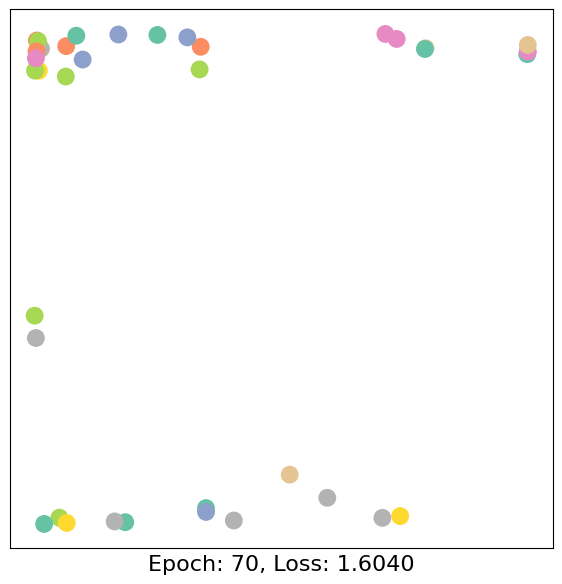

Epoch: 80, Loss: 1.5085, Train Acc: 0.5172, Val Acc: 0.2500


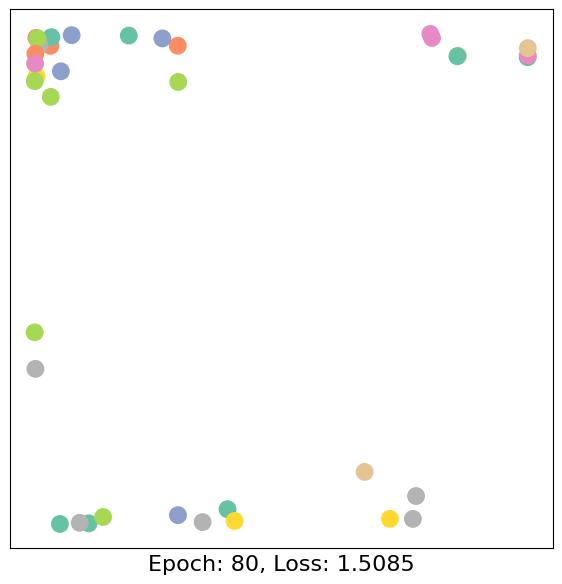

Epoch: 90, Loss: 1.4333, Train Acc: 0.5172, Val Acc: 0.2500


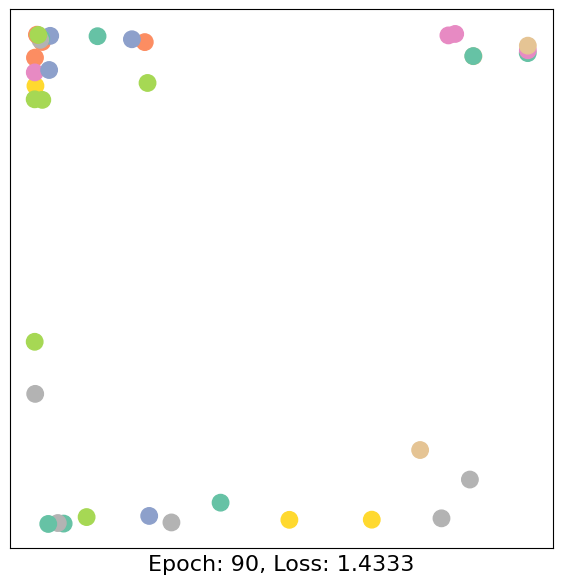

Epoch: 100, Loss: 1.3689, Train Acc: 0.5517, Val Acc: 0.2500


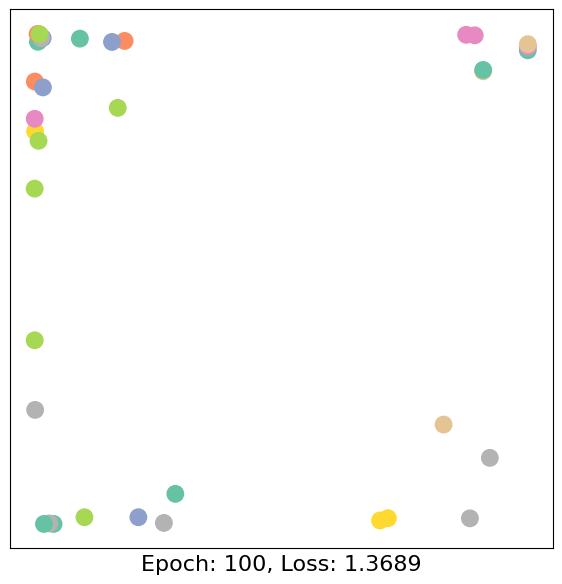

Epoch: 110, Loss: 1.3133, Train Acc: 0.5862, Val Acc: 0.2500


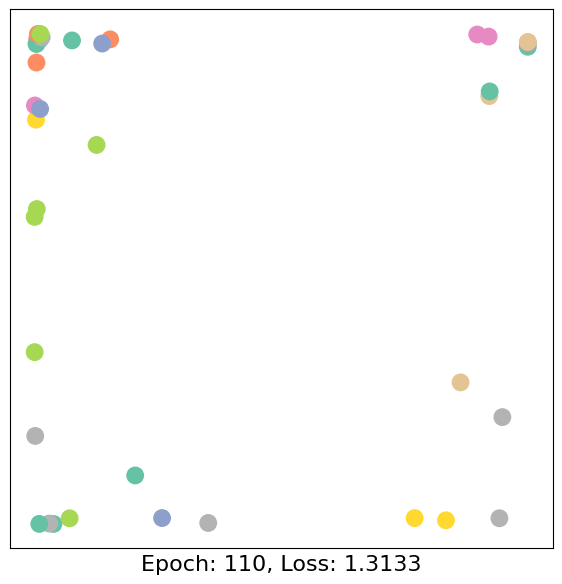

Epoch: 120, Loss: 1.2647, Train Acc: 0.5862, Val Acc: 0.2500


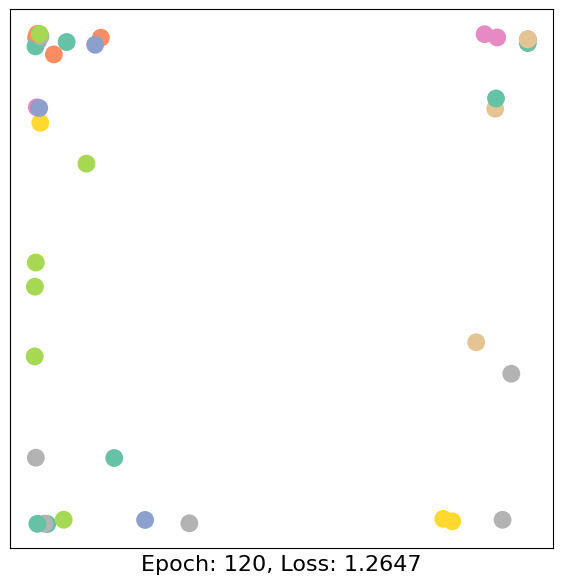

Epoch: 130, Loss: 1.2218, Train Acc: 0.5862, Val Acc: 0.2500


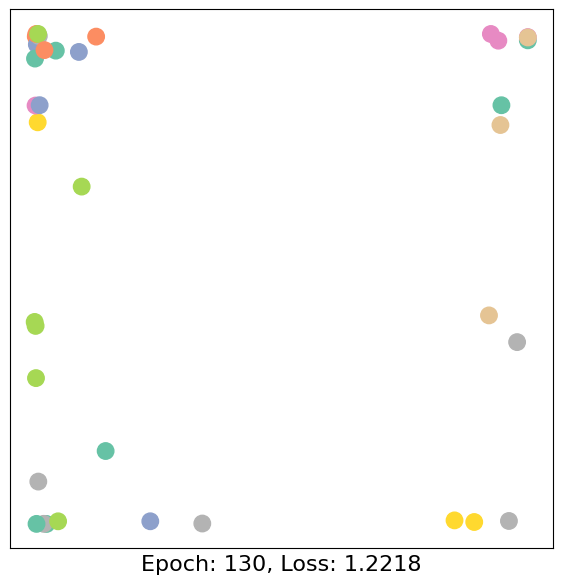

Epoch: 140, Loss: 1.1703, Train Acc: 0.5517, Val Acc: 0.2500


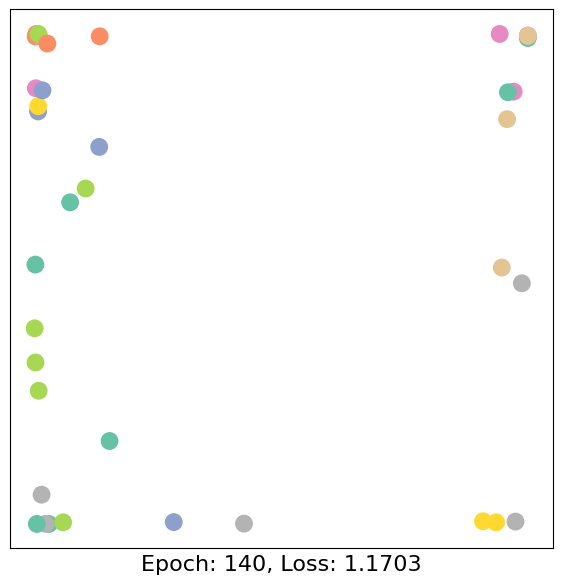

Epoch: 150, Loss: 1.1184, Train Acc: 0.5862, Val Acc: 0.2500


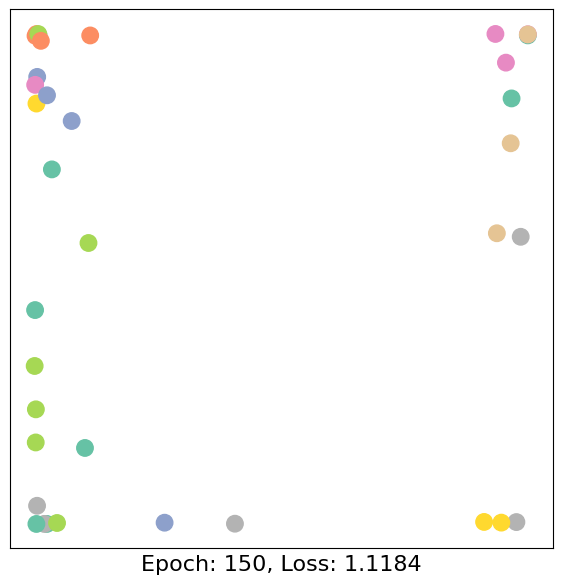

Epoch: 160, Loss: 1.0775, Train Acc: 0.5862, Val Acc: 0.2500


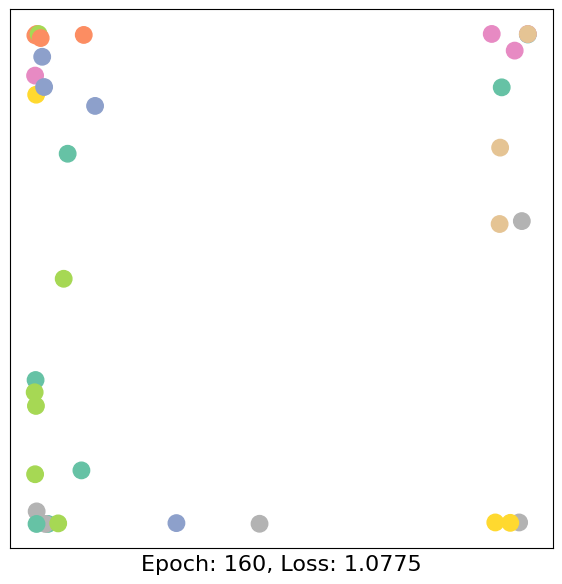

Epoch: 170, Loss: 1.0484, Train Acc: 0.5862, Val Acc: 0.2500


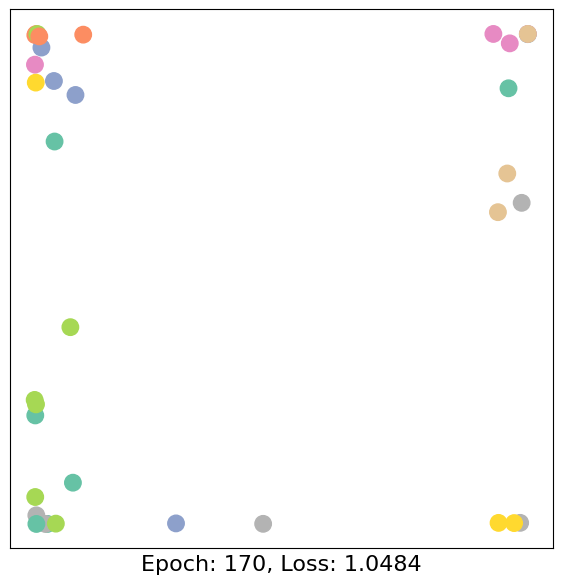

Epoch: 180, Loss: 1.0271, Train Acc: 0.5517, Val Acc: 0.2500


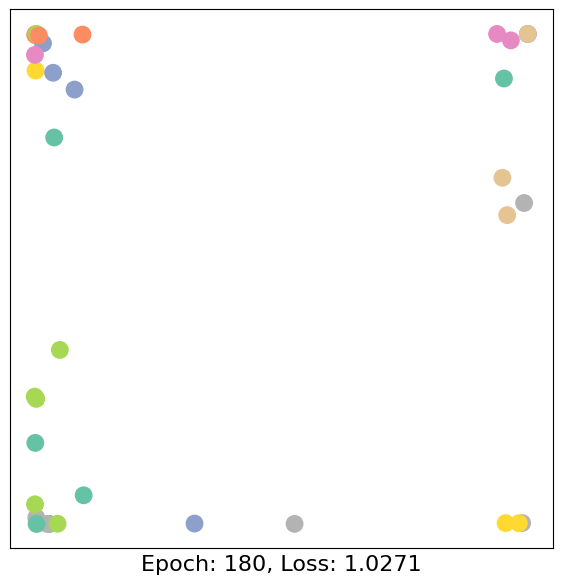

Epoch: 190, Loss: 1.0104, Train Acc: 0.5862, Val Acc: 0.2500


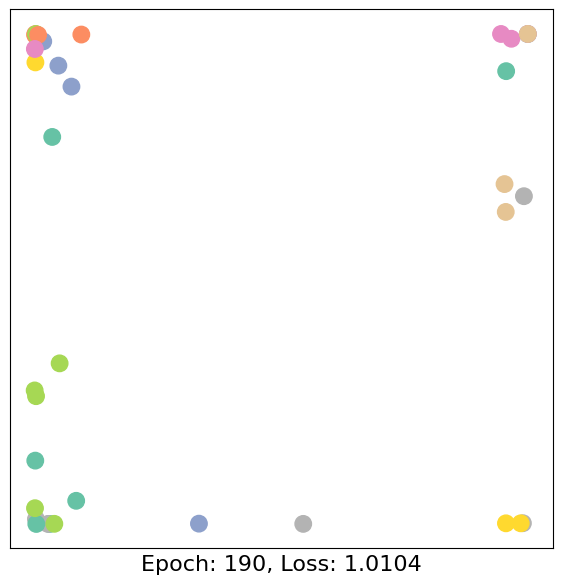

Epoch: 200, Loss: 0.9963, Train Acc: 0.5862, Val Acc: 0.2500


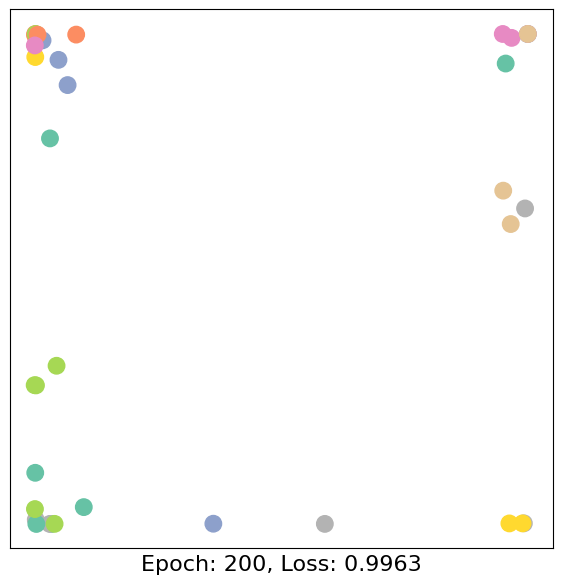

Epoch: 210, Loss: 0.9836, Train Acc: 0.6207, Val Acc: 0.2500


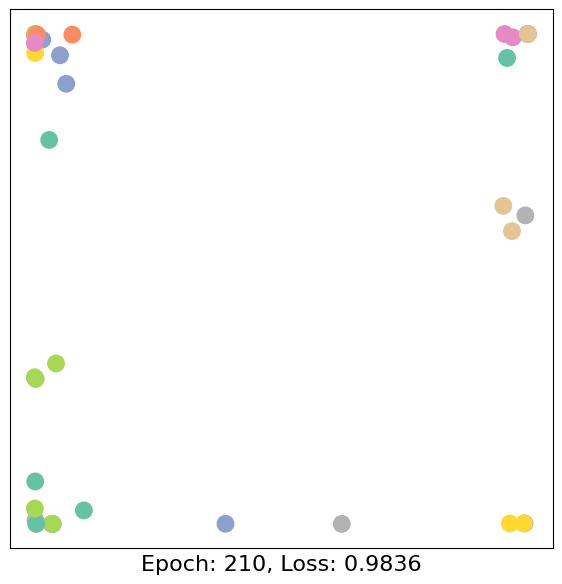

Epoch: 220, Loss: 0.9718, Train Acc: 0.6207, Val Acc: 0.2500


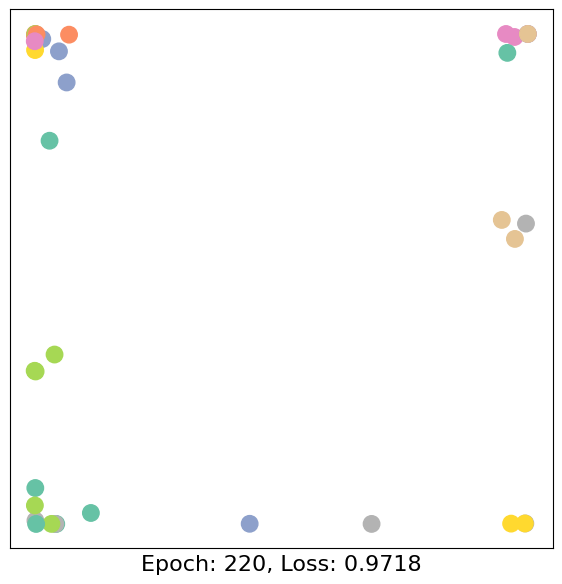

Epoch: 230, Loss: 0.9604, Train Acc: 0.6207, Val Acc: 0.2500


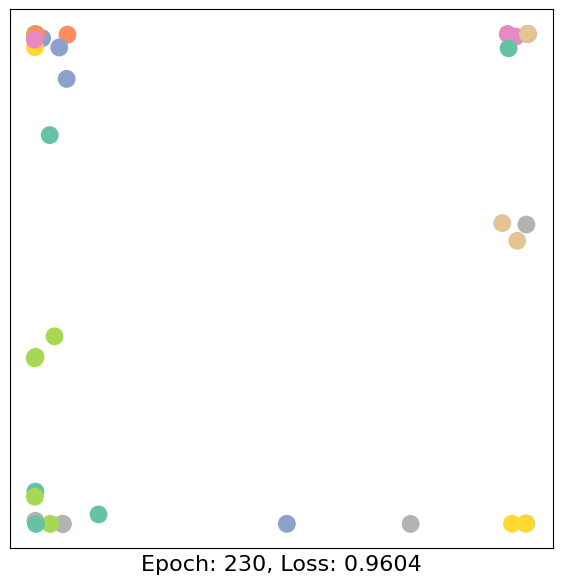

Epoch: 240, Loss: 0.9484, Train Acc: 0.6207, Val Acc: 0.2500


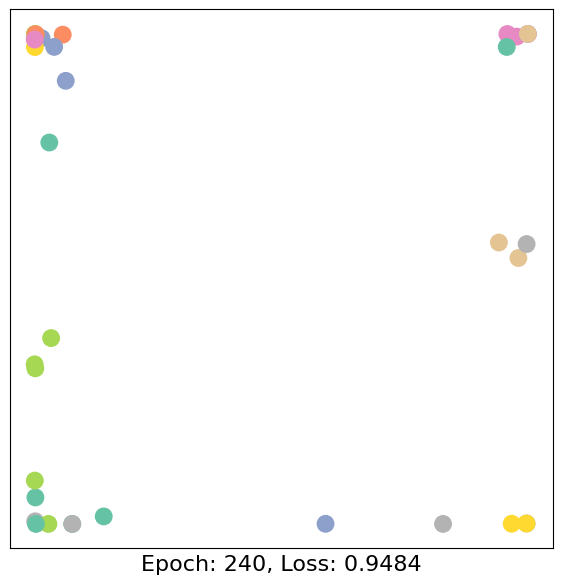

Epoch: 250, Loss: 0.9328, Train Acc: 0.6552, Val Acc: 0.2500


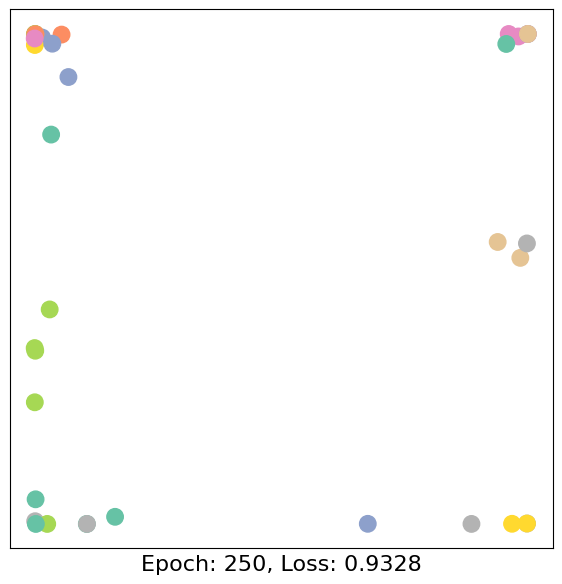

Epoch: 260, Loss: 0.9192, Train Acc: 0.6552, Val Acc: 0.2500


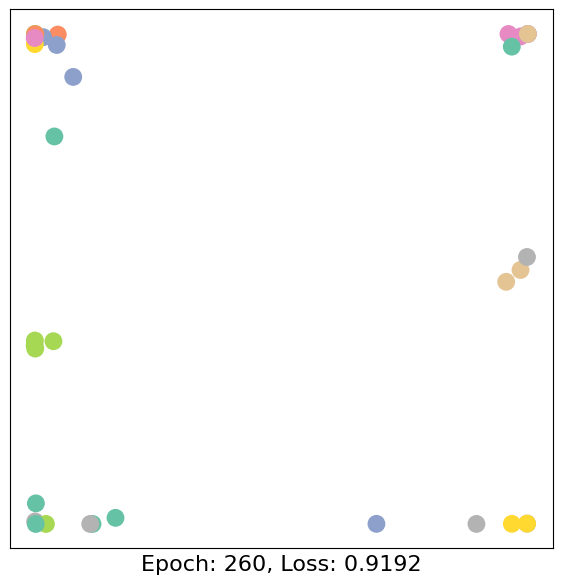

Epoch: 270, Loss: 0.9074, Train Acc: 0.6552, Val Acc: 0.2500


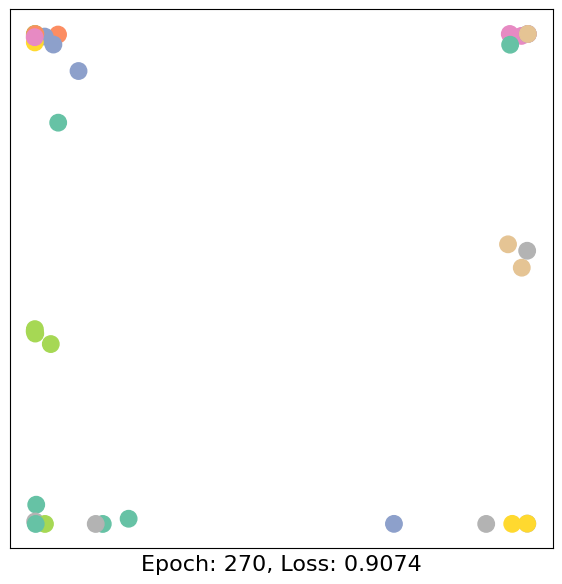

Epoch: 280, Loss: 0.8966, Train Acc: 0.6552, Val Acc: 0.2500


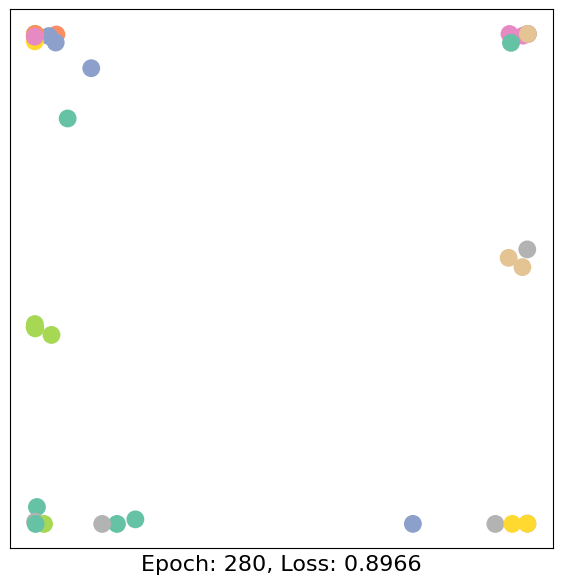

Epoch: 290, Loss: 0.8864, Train Acc: 0.6552, Val Acc: 0.2500


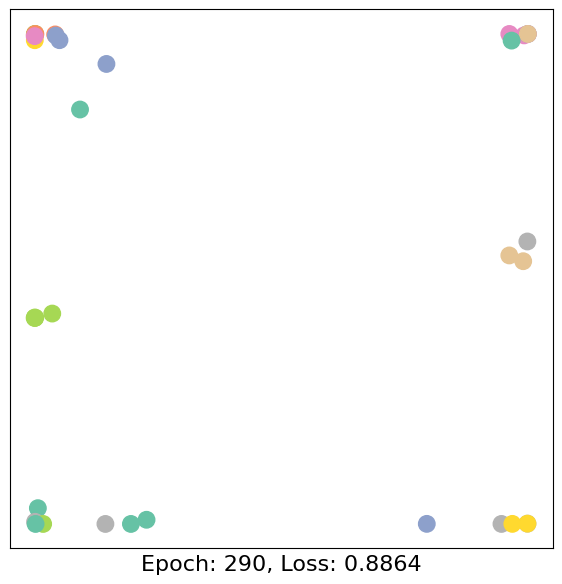

Epoch: 300, Loss: 0.8798, Train Acc: 0.6552, Val Acc: 0.2500


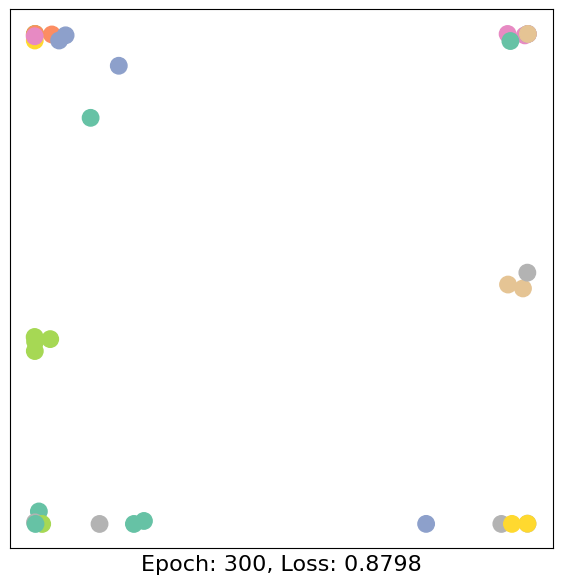

Epoch: 310, Loss: 0.8675, Train Acc: 0.6552, Val Acc: 0.2500


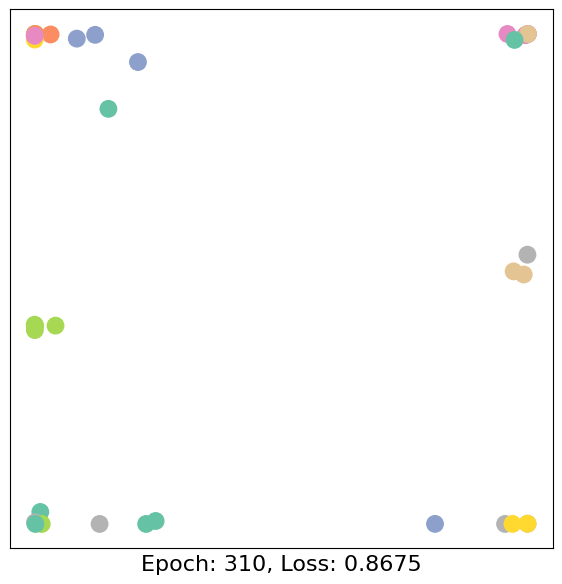

Epoch: 320, Loss: 0.8555, Train Acc: 0.6552, Val Acc: 0.2500


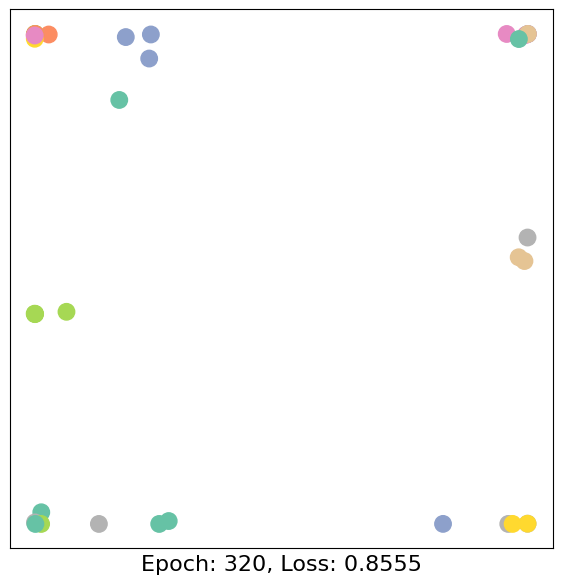

Epoch: 330, Loss: 0.8444, Train Acc: 0.6552, Val Acc: 0.2500


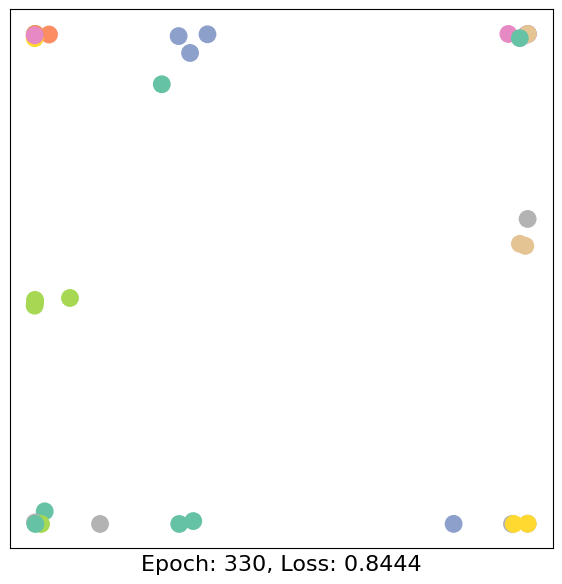

Epoch: 340, Loss: 0.8331, Train Acc: 0.7586, Val Acc: 0.2500


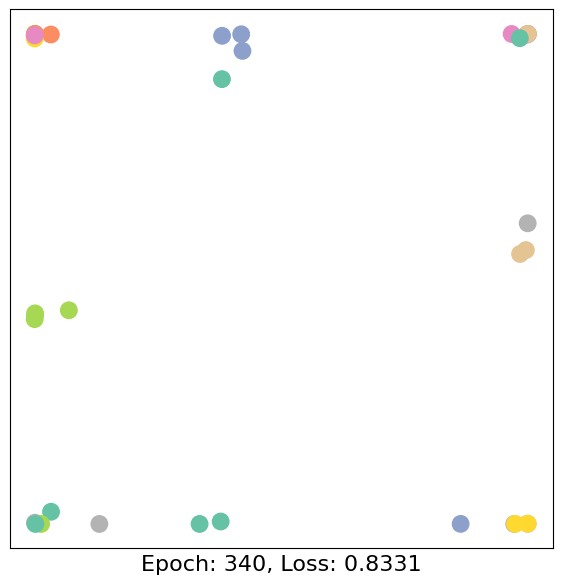

Epoch: 350, Loss: 0.8165, Train Acc: 0.7586, Val Acc: 0.2500


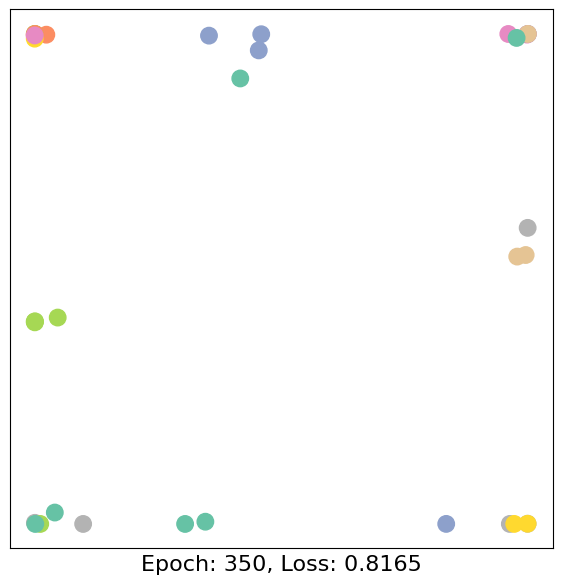

Epoch: 360, Loss: 0.7970, Train Acc: 0.7586, Val Acc: 0.2500


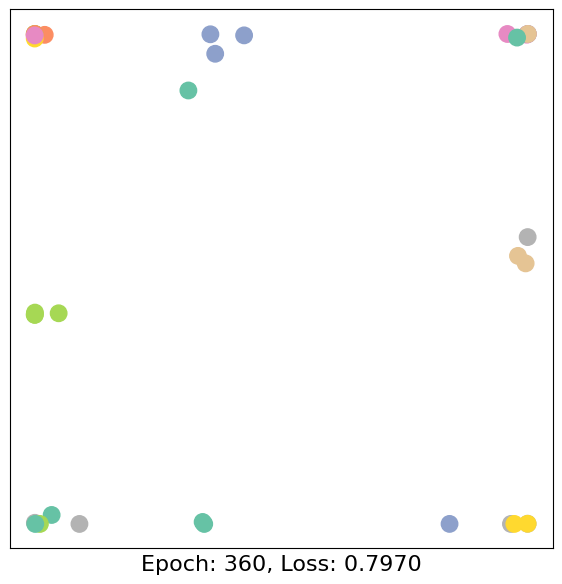

Epoch: 370, Loss: 0.7817, Train Acc: 0.7586, Val Acc: 0.2500


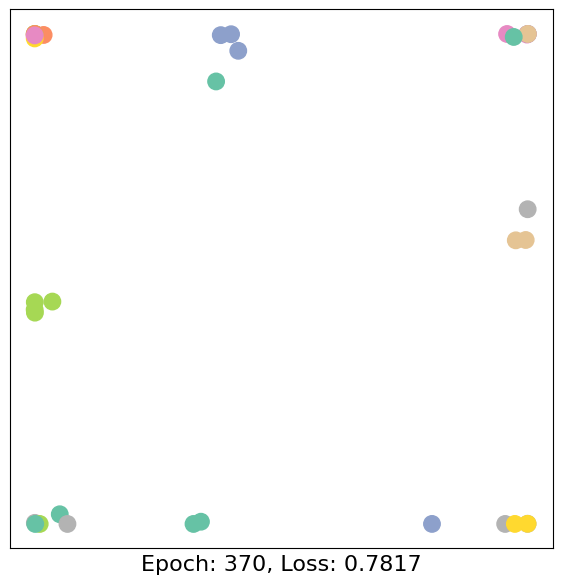

Epoch: 380, Loss: 0.7657, Train Acc: 0.7586, Val Acc: 0.2500


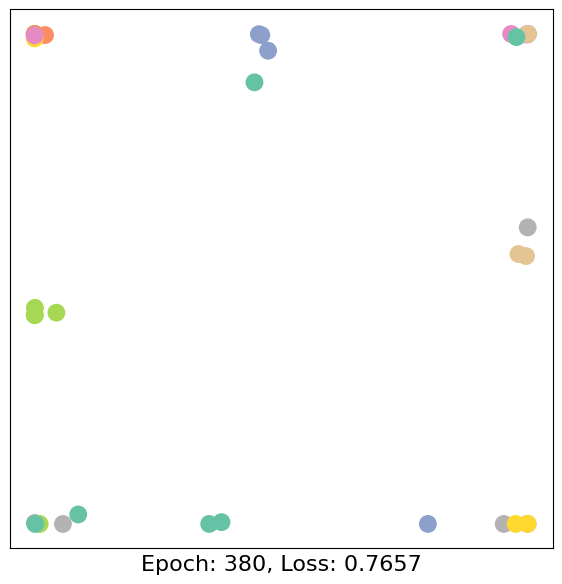

Epoch: 390, Loss: 0.7505, Train Acc: 0.7586, Val Acc: 0.2500


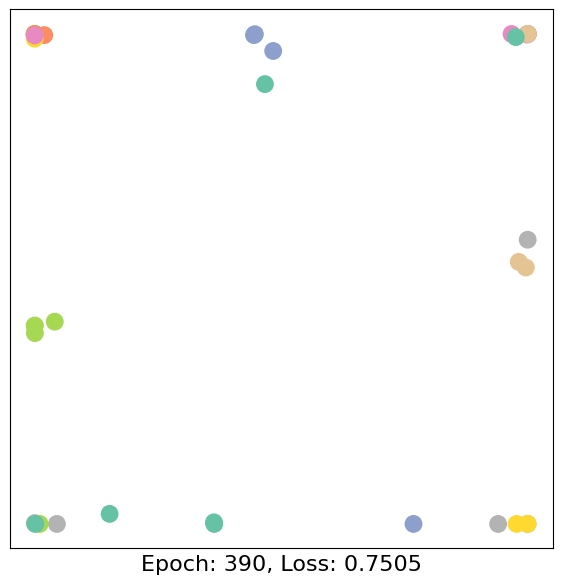

Epoch: 400, Loss: 0.7340, Train Acc: 0.7586, Val Acc: 0.2500


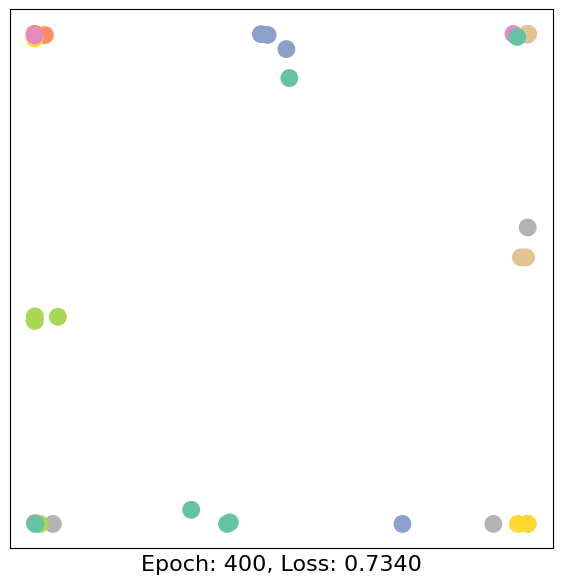

Final Train Accuracy: 0.7586
Final Validation Accuracy: 0.2500
Final Test Accuracy: 0.7500


In [249]:
import time
from IPython.display import Javascript  # Restrict height of output cell.
# Define accuracy calculation function
def accuracy(pred_y, y):
    return (pred_y == y).sum().item() / y.size(0)

# Setup
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 430})'''))

model = GCN()
criterion = torch.nn.CrossEntropyLoss()  # Define loss criterion.
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)  # Define optimizer.

def train(data):
    optimizer.zero_grad()  # Clear gradients.
    out, h = model(data.x, data.edge_index)  # Perform a single forward pass.
    loss = criterion(out[data.train_mask], data.y[data.train_mask])  # Compute the loss solely based on the training nodes.
    loss.backward()  # Derive gradients.
    optimizer.step()  # Update parameters based on gradients.
    return loss, h, out

for epoch in range(401):
    loss, h, out = train(data)
    if epoch % 10 == 0:
        pred = out.argmax(dim=1)
        train_acc = accuracy(pred[data.train_mask], data.y[data.train_mask])
        val_acc = accuracy(pred[data.val_mask], data.y[data.val_mask])
        print(f'Epoch: {epoch}, Loss: {loss:.4f}, Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}')
        visualize_embedding(h, color=data.y, epoch=epoch, loss=loss)
        time.sleep(0.3)

# Compute final accuracy
pred = out.argmax(dim=1)
train_acc = accuracy(pred[data.train_mask], data.y[data.train_mask])
val_acc = accuracy(pred[data.val_mask], data.y[data.val_mask])
test_acc = accuracy(pred[data.test_mask], data.y[data.test_mask])
print(f'Final Train Accuracy: {train_acc:.4f}')
print(f'Final Validation Accuracy: {val_acc:.4f}')
print(f'Final Test Accuracy: {test_acc:.4f}')

In [250]:
# Group and print node values by clusters
clusters = {}
for idx, cluster in enumerate(pred.tolist()):
    if cluster not in clusters:
        clusters[cluster] = []
    clusters[cluster].append(idx)

for cluster, nodes in clusters.items():
    print(f'Cluster {cluster}:')
    for node in nodes:
        node_id = graph_documents[0].nodes[node].id  # Get the node ID
        node_value = h[node].detach().cpu().numpy()
        print(f'  Node {node_id}: {node_value}')

Cluster 2:
  Node Albert Einstein: [-0.95865154  0.99544245]
  Node Theory Of Relativity: [-0.99966383  0.99361455]
  Node Mahatma Gandhi: [-0.99978155  0.99885106]
  Node Nonviolent Civil Disobedience: [-0.99996585  0.99973834]
  Node Indian Independence: [-0.99989384  0.99985653]
  Node Malala Yousafzai: [-0.9999322   0.98146945]
  Node I Am Malala: [-0.999803    0.99963486]
  Node Malala Fund: [-0.9999898  0.9939062]
Cluster 4:
  Node E=Mc²: [0.9415657 0.9998145]
  Node Chemistry: [0.9977207 0.9977933]
  Node Nelson Mandela: [0.99999774 0.9999758 ]
  Node Apartheid: [0.99999994 0.9999969 ]
  Node South Africa: [0.99999994 0.99999654]
  Node Literature: [0.9566335 0.9878895]
Cluster 3:
  Node Marie Curie: [0.02070119 0.9382821 ]
  Node Radioactivity: [-0.0825225  0.9991665]
  Node Physics: [0.03282797 0.8198555 ]
  Node Education: [-0.05512027  0.99591064]
Cluster 1:
  Node Nobel Prize: [-0.36530718 -0.9422882 ]
  Node I Have A Dream: [-0.20847955 -0.99340314]
  Node Frida Kahlo: [-0